Imports

In [1]:
import numpy as np
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import json
import seaborn as sns

In [2]:
GPU_INDEX=5
isGPU = True


isTest=''
# isTest = 'test-'
# isTest = 'new-'

# MODEL_NAME = "resnet"
MODEL_NAME = "lenet5"

############################

NUM_EPOCHES = 40
NUM_CLASS = 100
EPOCH_THRES=5
BATCH_SIZE=256

DATA_NAME="cifar"


DATA_DIR = f'./data/{DATA_NAME}-{NUM_CLASS}'


############################

## STRATEGY A: Single Thresholding
# thresholds = [[0.1], [0.2],[0.3], [0.4], [0.5], [0.6], [0.7],[0.8], [0.9]]
# to_keep = [[False, True]]*len(thresholds)

## STRATEGY B: Range-based Thresholding (easy, medium, hard)
# thresholds = [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7]]
# to_keep = [[False, True, True] , [False, True, True], [False, True, True]]

## STRATEGY C: Range-based Thresholding (very easy, easy, medium, hard)
# thresholds = [[0.1, 0.3, 0.7], [0.15, 0.5, 0.85]]
# to_keep = [[False, True, True, False], [False, True, True, False]]



## EXPERIMENTING WITH DIFFERENT STRATEGIES
thresholds = [[0.1], [0.2], [0.2, 0.8], [0.15, 0.5, 0.85], [0.1, 0.4, 0.7]]
to_keep = [[False, True], [False, True], [False, True, True], [False, True, True, False], [False, True, True, False]]


In [3]:
print( f'\n\nRUNNING NOTEBOOK MODEL : {isTest}{MODEL_NAME}, DATA: {DATA_NAME}-{NUM_CLASS}' )



RUNNING NOTEBOOK MODEL : lenet5, DATA: cifar-100


In [4]:
 # HF model
# HF_API_TOKEN = os.getenv("HF_API_TOKEN")


if isGPU:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" ## to avoid Context Switching 
    os.environ["HF_HOME"]= "/data2/meithnav/.hfcache/"
    os.environ["CUDA_VISIBLE_DEVICES"]=str(GPU_INDEX) # not changing GPU. Only 
    os.environ["WANDB_DISABLED"] = "true"
    # os.environ["CUDA_VISIBLE_DEVICES"]=str(GPU_INDEX) # not changing GPU. Only 


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
torch.manual_seed(42)


if isGPU:
    torch.cuda.set_device(0) ## setgpu
    print("\n\n--> CONNECTED TO GPU NO: ", torch.cuda.current_device())
    print("--> GPU_INDEX: ", GPU_INDEX)
        
    # GPU (MPS for Apple Silicon, CUDA for Nvidia GPUs, or CPU)

    torch.cuda.empty_cache() # clear GPU cache
    torch.cuda.reset_max_memory_allocated()


device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# APPEND ROOT DIRECTORY
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Forgetability Experiments'), '..')))


print(os.getcwd())


os.makedirs('./models', exist_ok=True)
os.makedirs(f'./models/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}' ,  exist_ok=True)
os.makedirs('./outputs',  exist_ok=True)
os.makedirs('./outputs/plots',  exist_ok=True)
os.makedirs(f'./outputs/plots/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}',  exist_ok=True)
os.makedirs('./outputs/results',  exist_ok=True)
os.makedirs(f'./outputs/results/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}' ,  exist_ok=True)





--> CONNECTED TO GPU NO:  0
--> GPU_INDEX:  5
/data2/meithnav/projects/forgetabilityTraining


/data2/meithnav/anaconda3/envs/domianins/lib/python3.11/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [5]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == targets).sum().item()
            total += targets.size(0)
    return correct / total

In [6]:
class ForgetabilityTracker:
    def __init__(self, dataset_size):
        self.misclassification_counts = np.zeros(dataset_size, dtype=np.int32)

    def update(self, predictions, labels, indices, subset_mapping=None):
        incorrect_predictions = predictions != labels
        incorrect_predictions = incorrect_predictions.cpu().numpy()
        indices = indices.cpu().numpy()
        
        if subset_mapping is not None:
            # Map indices from subset to original dataset
            indices = subset_mapping[indices]
        
        self.misclassification_counts[indices] += incorrect_predictions

    def get_scores(self):
        return self.misclassification_counts


In [7]:
def plot_distribution(data, title="Distribution Plot", xlabel="Values", ylabel="Frequency", kde=True, path='./'):
   
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data, fill=True, color="blue", alpha=0.7, bw_adjust=0.5)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlim(0, 1)
    plt.grid(alpha=0.3)
    plt.savefig(f'{path}.png')
    plt.show()

### LeNet-5 & ResNet18

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(nn.MaxPool2d(2)(self.conv1(x)))
        x = torch.relu(nn.MaxPool2d(2)(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out



class ResNet18(nn.Module):
    def __init__(self, num_classes=NUM_CLASS):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # Initial Convolutional Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, NUM_CLASS)

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


### Training loop

In [ ]:
def train_model(model, optimizer, criterion, train_loader, test_loader, tracker=None, epoch_threshold=5, thresholds_arr=None, to_keep=None, num_epochs = NUM_EPOCHES):
    
    current_loader = train_loader  # Use the initial loader for the first phase
    results = {
        "time":[],
        "accuracy":[],
        "size":[]
    }
    for epoch in range(num_epochs):

        start_ep = time.time()
        model.train()

        # Training loop
        for batch_idx, (data, targets) in tqdm(
            enumerate(current_loader), desc=f"Epoch {epoch + 1}/{num_epochs}"
        ):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            if tracker:
                # Handle subset mapping for indices
                if isinstance(current_loader.dataset, Subset):
                    subset_mapping = np.array(current_loader.dataset.indices)
                else:
                    subset_mapping = None

                batch_indices = batch_idx * current_loader.batch_size + torch.arange(data.size(0)).to(device)
                tracker.update(predictions, targets, batch_indices, subset_mapping=subset_mapping)

        
        
        # Update dataset every `epoch_threshold` epochs if tracker is enabled
        if tracker and thresholds_arr and (epoch + 1) % epoch_threshold == 0:
            # print(f"Epoch {epoch + 1}: Evaluating forgetability and updating dataset...")

            
            # Get forgetability scores and normalize
            forgetability_scores = tracker.get_scores()
            # print(forgetability_scores)
            # print(len(forgetability_scores))
            
            normalized_scores = (forgetability_scores - np.min(forgetability_scores)) / (np.max(forgetability_scores) - np.min(forgetability_scores))

            # normalized_scores = forgetability_scores / (epoch+1)
            
            plot_distribution(normalized_scores, title="Forgettability Scores Distribution", xlabel="Values", ylabel="Density", path=f'./outputs/plots/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}/Distri-Plot-{epoch+1}' )
            
            # Multi-threshold case: Create distinct bins
            bin_indices = []
            for i, threshold in enumerate(thresholds_arr):
                if i == 0:
                    bin_indices.append(np.where(normalized_scores <= threshold)[0])
                else:
                    bin_indices.append(
                        np.where((normalized_scores > thresholds_arr[i - 1]) & (normalized_scores <= threshold))[0]
                    )
            bin_indices.append(np.where(normalized_scores > thresholds_arr[-1])[0])

            # Filter bins based on `to_keep`
            if to_keep is not None:
                if len(to_keep) != len(bin_indices):
                    raise ValueError(
                        f"Invalid `to_keep` length. Expected {len(bin_indices)} booleans, but got {len(to_keep)}."
                    )
                bin_indices = [bin for bin, keep in zip(bin_indices, to_keep) if keep]

            indices_to_keep = np.concatenate(bin_indices) if bin_indices else np.array([], dtype=int)
            # print(f"\n\n-> Keeping {len(indices_to_keep)} out of {len(forgetability_scores)} datapoints.")

            # Create a mapping from subset indices to original dataset indices
            subset_mapping = indices_to_keep

            # Update the training dataset
            current_loader = DataLoader(
                Subset(train_loader.dataset, indices_to_keep),
                batch_size=train_loader.batch_size,
                shuffle=True
            )


        end_ep = time.time()

        
        accuracy_ep = evaluate_model(model, test_loader)
        results['time'].append(end_ep - start_ep)
        results['accuracy'].append(accuracy_ep)
        results['size'].append(len(current_loader.dataset))
        
        
        print(f"-> EPOCH {epoch+1}, TEST ACCURACY: {accuracy_ep*100:.4f}%, TIME: {end_ep-start_ep:.3f} sec\n")
        if tracker and thresholds_arr and (epoch + 1) % epoch_threshold == 0:
            print(f"Epoch {epoch + 1}: Evaluating forgetability and updating dataset...")
            print(f"\n\n-> Keeping {len(indices_to_keep)} out of {len(forgetability_scores)} datapoints.")
            


    
    return results
            

### Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if NUM_CLASS==10:
    train_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transform)
elif NUM_CLASS==100: 
    train_dataset = torchvision.datasets.CIFAR100(root=DATA_DIR, train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR100(root=DATA_DIR, train=False, download=True, transform=transform)
else: 
    train_dataset=None
    test_dataset=None



In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
if MODEL_NAME == "resnet": 
    model= ResNet18(num_classes=NUM_CLASS).to(device)

elif MODEL_NAME == "lenet5":
    model= LeNet5(num_classes=NUM_CLASS).to(device)
else: 
    model= None


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
results_array = {}

In [ ]:
### BASELINE Train on the entire dataset

print(f"\n\n****\nTraining baseline model: {MODEL_NAME}...")
start = time.time()
results = train_model(model, optimizer, criterion, train_loader, test_loader)
end = time.time()
accuracy= evaluate_model(model, test_loader)
results_array[ "baseline" ] = results

print(f"\n\n -> BASELINE TEST ACCURACY: {accuracy*100:.4f}%,, TIME: {end-start:.3f} sec\n")
print( f'{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}-strategy-{ "-".join(map(str, to_keep[0])) }' )

## Experimenting for different thresholding strategies and values

In [ ]:
accuracies = []
training_time =[]
times = []

for idx, thres in tqdm(enumerate(thresholds)):
    print(f"\n\n\n\n********\n-> RUNNING THRESHOLD: {thres}, MODEL: {MODEL_NAME}, DATASET: {DATA_NAME}-{NUM_CLASS}")
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    start = time.time()
    # Initialize the model, optimizer, and loss function
    
    if MODEL_NAME == "resnet": 
        model_dynamic = ResNet18(num_classes=NUM_CLASS).to(device)

    elif MODEL_NAME == "lenet5":
        model_dynamic = LeNet5(num_classes=NUM_CLASS).to(device)
    else: 
        model= None

    
    optimizer_dynamic = optim.Adam(model_dynamic.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Initialize the tracker
    tracker_dynamic = ForgetabilityTracker(len(train_dataset))

    # Train the model
    results = train_model(
        model_dynamic, optimizer_dynamic, criterion,
        train_loader, test_loader, tracker_dynamic,
        epoch_threshold=EPOCH_THRES, thresholds_arr=thres,
        to_keep=to_keep[idx]
    )

    end = time.time()
    # Evaluate the model
    accuracy_dynamic = evaluate_model(model_dynamic, test_loader)
    accuracies.append(accuracy_dynamic)
    results_array["-".join(map(str, thres))] = results
    times.append(end-start)
    
    # Save the model
    torch.save(model_dynamic, f'./models/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}/thres-{ "-".join(map(str, thres)) }-strategy-{ "-".join(map(str, to_keep[idx])) }.pt')


    print(f"-> TEST ACCURACY: {accuracy_dynamic}, THRESHOLD: {thres}, TIME: {end-start:.3f} sec\n")

In [ ]:
# print("THRESHOLDS : " , thresholds)
# print("ACCURACIES : " , accuracies)
# print("TIME TAKEN", times)
# print( f'{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}-strategy-{ "-".join(map(str, to_keep[0])) }' )

### PROPOSED STRATEGY

In [16]:
epoch_split_per_phase = [10, 16, 14], ## num of epochs for each phase 
threshold_subsets = [0.2, 0.8],   ## forgettability thresholds for subsets ( [0 , 0.2) -> easy, [0.2, 0.8) -> medium, [0.8-1] -> hard] )
subset_to_keep_strategy_arr_per_phase = [[True, True, False], [False, True, False], [False, False, True]], ## dataselection strategy for each phase

In [ ]:
def proposed_cpt(
    epochs,
    threshold,
    strategies,
    train_dataset,
    test_dataset,
    epoch_threshold=5,
):
    train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
    results = {
                "time":[],
               "size":[],
               "accuracy":[]
            }

    if MODEL_NAME == "resnet": 
        model= ResNet18(num_classes=NUM_CLASS).to(device)

    elif MODEL_NAME == "lenet5":
        model= LeNet5(num_classes=NUM_CLASS).to(device)
    else: 
        model= None
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    start = time.time()
    tracker = ForgetabilityTracker(len(train_loader.dataset))
    for i in range(len(epochs)):
        t_result = train_model(
                                            model,
                                            optimizer,
                                            criterion,
                                            train_loader,
                                            test_loader,
                                            tracker,
                                            epoch_threshold,
                                            threshold,
                                            strategies[i],
                                            epochs[i],
                                )
        results['time'].extend(t_result['time'])
        results['accuracy'].extend(t_result['accuracy'])
        results['size'].extend(t_result['size'])
        
    end = time.time()
    accuracy_dynamic = evaluate_model(model, test_loader)
    # results_array["-".join(map(str, thres))] = results
    # times.append(end-start)
    
    # Save the model
    torch.save(model, f'./models/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}/proposed-thres-{ "-".join(map(str, threshold)) }.pt')

    print(f"-> TEST ACCURACY: {accuracy_dynamic}, THRESHOLD: {threshold}, TIME: {end-start:.3f} sec\n")
    return results
        

In [ ]:
results = proposed_result = proposed_cpt(
    epoch_split_per_phase,
    threshold_subsets,
    subset_to_keep_strategy_arr_per_phase,
    train_dataset,
    test_dataset,
    epoch_threshold=5, ## EPOCH_ACCUMULATE
)

In [ ]:
results_array["proposed_cpt"] = results

In [ ]:
with open(f'./outputs/results/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}/results-strategy-{ "-".join(map(str, to_keep[0])) }.json', 'w') as f:
    json.dump(results_array, f)

## PLOT

In [ ]:
with open(f'./outputs/results/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}/results-strategy-{ "-".join(map(str, to_keep[0])) }.json', 'r') as f:
    results_array = json.load(f)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

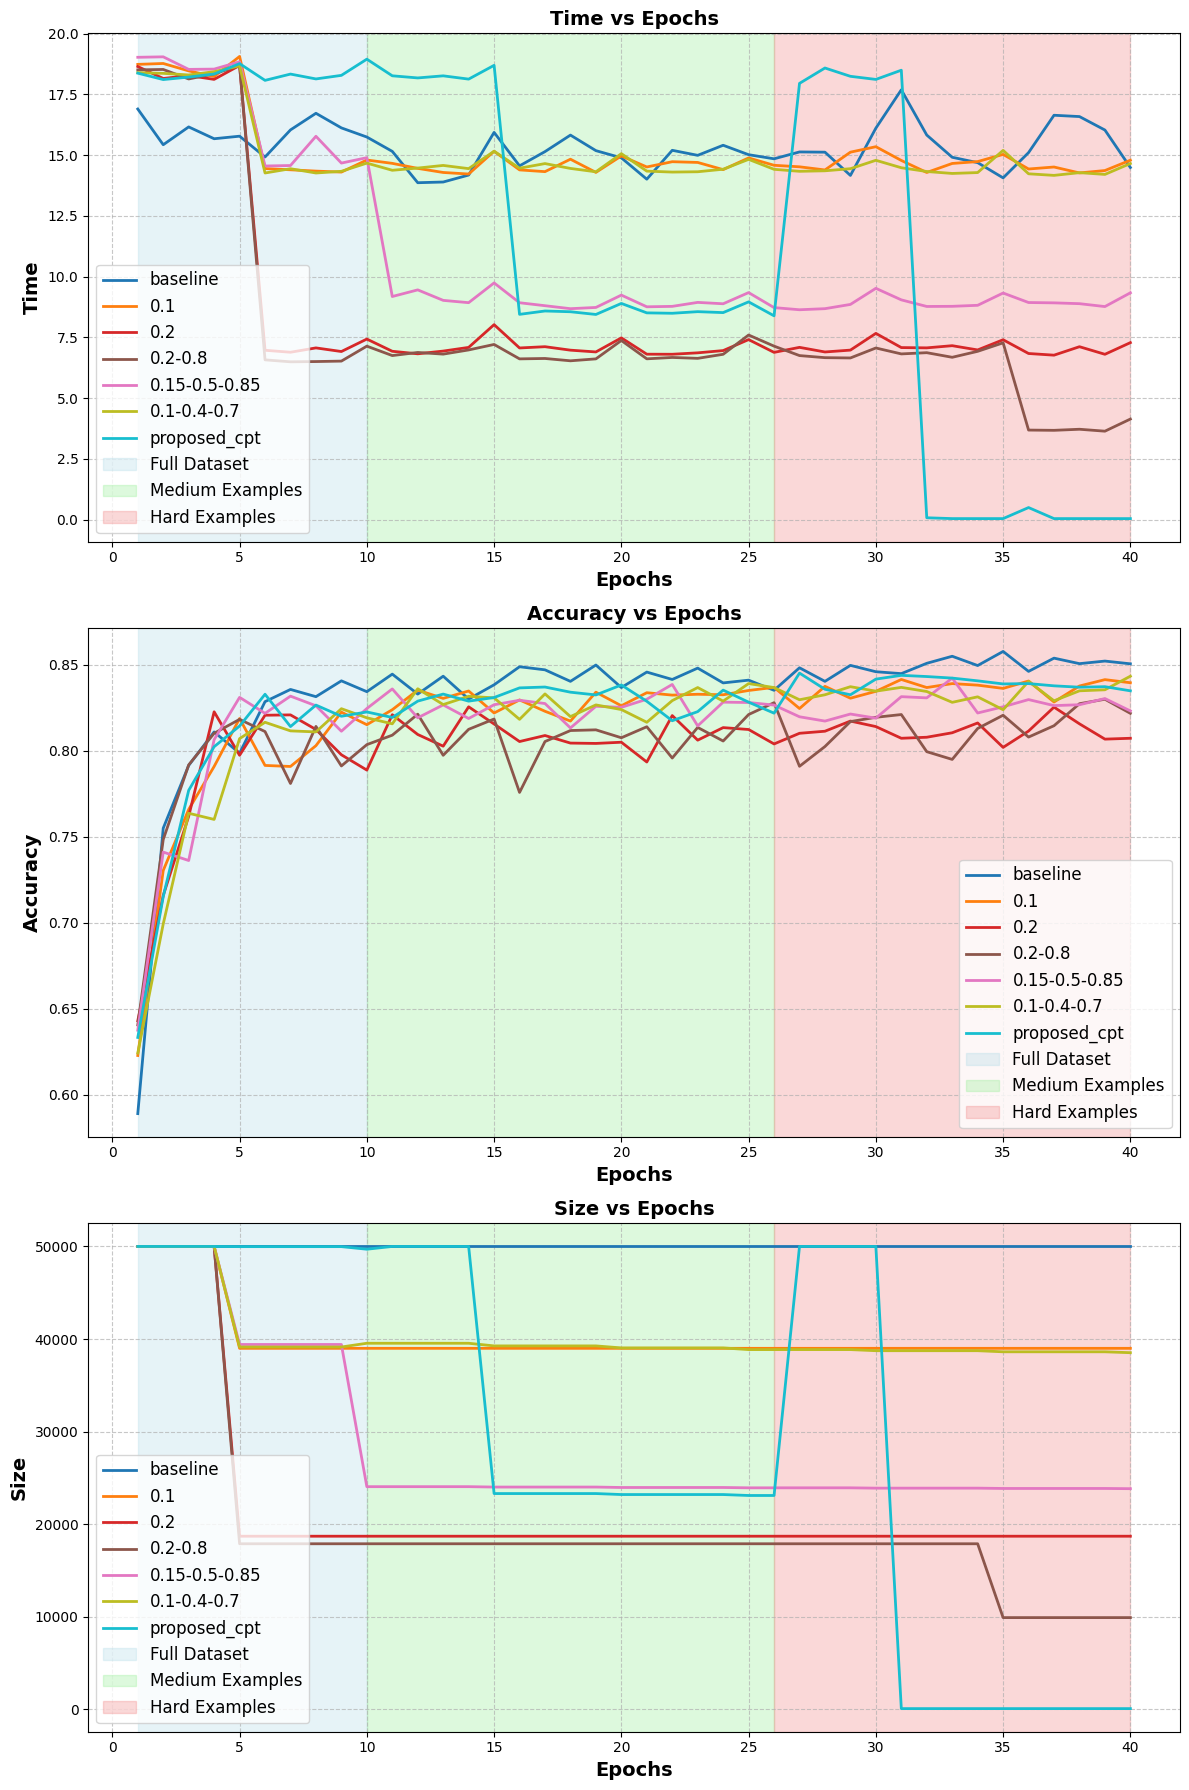

In [26]:
data = results_array
# Prepare data for plotting
configs = list(data.keys())  # e.g., ['baseline', '0.8', '0.7']

# Generate a colormap
num_configs = len(configs)
colors = cm.tab10(np.linspace(0, 1, num_configs))  # Use 'tab10' for distinct colors

# Common styling
font = {'family': 'Arial', 'weight': 'bold', 'size': 14}  # Font for labels and titles
line_width = 2  # Thickness of lines
legend_font_size = 12  # Legend font size

# Initialize subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))  # Larger plot size for better readability

# Plot Time vs Epochs
for idx, config in enumerate(configs):
    epochs = list(range(1, len(data[config]["time"]) + 1))
    time_data = data[config]["time"]
    axes[0].plot(
        epochs, time_data, label=f"{config}", color=colors[idx], linewidth=line_width
    )

axes[0].set_xlabel("Epochs", fontdict=font)
axes[0].set_ylabel("Time", fontdict=font)
axes[0].set_title("Time vs Epochs", fontdict=font)
axes[0].legend(fontsize=legend_font_size)
axes[0].grid(True, linestyle="--", alpha=0.7)  # Dashed grid lines for clarity

# Plot Accuracy vs Epochs
for idx, config in enumerate(configs):
    epochs = list(range(1, len(data[config]["accuracy"]) + 1))
    accuracy = data[config]["accuracy"]
    axes[1].plot(
        epochs, accuracy, label=f"{config}", color=colors[idx], linewidth=line_width
    )

axes[1].set_xlabel("Epochs", fontdict=font)
axes[1].set_ylabel("Accuracy", fontdict=font)
axes[1].set_title("Accuracy vs Epochs", fontdict=font)
axes[1].legend(fontsize=legend_font_size)
axes[1].grid(True, linestyle="--", alpha=0.7)

# Plot Size vs Epochs
for idx, config in enumerate(configs):
    epochs = list(range(1, len(data[config]["size"]) + 1))
    size = data[config]["size"]
    axes[2].plot(
        epochs, size, label=f"{config}", color=colors[idx], linewidth=line_width
    )

axes[2].set_xlabel("Epochs", fontdict=font)
axes[2].set_ylabel("Size", fontdict=font)
axes[2].set_title("Size vs Epochs", fontdict=font)
axes[2].legend(fontsize=legend_font_size)
axes[2].grid(True, linestyle="--", alpha=0.7)

# Define the epoch ranges for shading
full_dataset_range = (1, 10)  # Replace with the actual range for full dataset training
medium_examples_range = (10, 26)  # Replace with the actual range for medium examples
hard_examples_range = (26, 40)  # Replace with the actual range for hard examples

# Colors for the shaded regions
shaded_colors = ["lightblue", "lightgreen", "lightcoral"]

# Add shading to each plot
for ax in axes:
    # Shade full dataset range
    ax.axvspan(
        full_dataset_range[0],
        full_dataset_range[1],
        color=shaded_colors[0],
        alpha=0.3,
        label="Full Dataset"
    )
    # Shade medium examples range
    ax.axvspan(
        medium_examples_range[0],
        medium_examples_range[1],
        color=shaded_colors[1],
        alpha=0.3,
        label="Medium Examples"
    )
    # Shade hard examples range
    ax.axvspan(
        hard_examples_range[0],
        hard_examples_range[1],
        color=shaded_colors[2],
        alpha=0.3,
        label="Hard Examples"
    )

# Add legends for the shaded regions to the first plot
axes[0].legend(fontsize=legend_font_size, loc="lower left")
axes[1].legend(fontsize=legend_font_size, loc="lower right")
axes[2].legend(fontsize=legend_font_size, loc="lower left")
# Adjust layout
plt.tight_layout()
plt.savefig(f'./outputs/plots/{isTest}{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}/proposed-comparison-{MODEL_NAME}-{DATA_NAME}-{NUM_CLASS}.png')
plt.show()

In [27]:
print( f'\n\nRAN MODEL : {isTest}{MODEL_NAME}, DATA: {DATA_NAME}-{NUM_CLASS}' )



RAN MODEL : lenet5, DATA: cifar-100


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


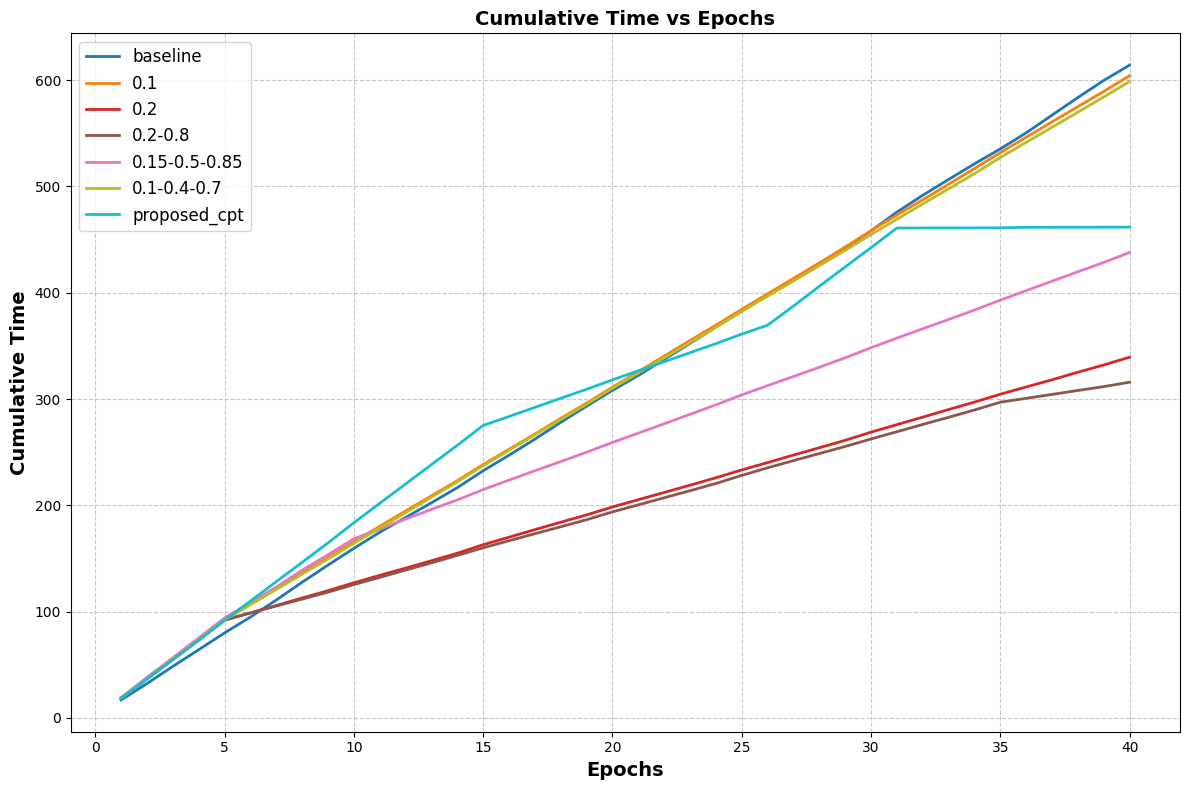

In [28]:
def plot_cumulative_time_vs_epochs(data, colors=None):
    
    configs = list(data.keys())  # e.g., ['baseline', '0.8', '0.7']
    num_configs = len(configs)

    # Generate a colormap if colors are not provided
    if colors is None:
        colors = cm.tab10(np.linspace(0, 1, num_configs))

    # Common styling
    font = {'family': 'Arial', 'weight': 'bold', 'size': 14}
    line_width = 2
    legend_font_size = 12

    # Initialize plot
    plt.figure(figsize=(12, 8))

    # Plot Cumulative Time vs Epochs
    for idx, config in enumerate(configs):
        epochs = np.arange(1, len(data[config]["time"]) + 1)
        time_data = data[config]["time"]
        cumulative_time = np.cumsum(time_data)
        plt.plot(epochs, cumulative_time, label=f"{config}", color=colors[idx], linewidth=line_width)

    plt.xlabel("Epochs", fontdict=font)
    plt.ylabel("Cumulative Time", fontdict=font)
    plt.title("Cumulative Time vs Epochs", fontdict=font)
    plt.legend(fontsize=legend_font_size)
    plt.grid(True, linestyle="--", alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.savefig('./outputs/plots/cumulative_time_vs_epochs.png')
    plt.show()



# Plot
plot_cumulative_time_vs_epochs(results_array)